# Occultation Probability Calculator

This notebook calculates the geometric probability of observing occultations (secondary eclipses) for exoplanets, based on the theoretical framework presented in Winn (2014) "Transits and Occultations" and related literature.

## Physical Context

An **occultation** (or secondary eclipse) occurs when the planet passes behind its host star as viewed from Earth. Unlike transits where the planet blocks starlight, occultations involve the temporary disappearance of thermal emission from the planet's day side.

The geometric probability of observing an occultation is fundamentally related to the orbital geometry and is nearly identical to the transit probability for circular orbits.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import constants
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

print("Occultation Probability Calculator - Ready!")
print("Based on Winn (2014) and standard exoplanet theory")

Occultation Probability Calculator - Ready!
Based on Winn (2014) and standard exoplanet theory


## Theoretical Background

### Basic Geometric Probability

From Winn's paper, the probability of observing an occultation is given by:

$$p_{\text{occ}} = \frac{R_\star + R_p}{a} \, \frac{1 + e \sin \omega}{1 - e^2}$$

Where:
- $R_\star$ = **stellar radius**
- $R_p$ = **planetary radius**  
- $a$ = **orbital semi-major axis**
- $e$ = **orbital eccentricity**
- $\omega$ = **argument of periastron** (the angle that tells us where the planet is closest to the star relative to our line of sight)

### For Circular Orbits (e = 0):
$$P_{occ} = \frac{R_\star + R_p}{a}$$

This is identical to the transit probability for circular orbits.

### Key Differences from Transits:
1. **Timing**: Occultations occur at secondary eclipse (phase ~0.5)
2. **Signal**: Loss of planetary thermal emission rather than stellar flux reduction
3. **Geometry**: For eccentric orbits, the probability depends on the argument of periastron and eccentricity
4. **Formula**: Uses $\sin \omega$ rather than $\cos \omega$ due to the phase difference between transit and occultation

## Important Note on Formula Correction

⚠️ **Updated Formula**: This notebook now uses the correct formula from Winn (2014):

$$p_{\text{occ}} = \frac{R_\star + R_p}{a} \, \frac{1 + e \sin \omega}{1 - e^2}$$

**Key differences from previous versions:**
- Uses $\sin \omega$ instead of $\cos \omega$ 
- Includes the $(1 - e^2)$ factor in the denominator
- This accounts for the proper orbital mechanics of secondary eclipses

**Physical meaning:** The $\sin \omega$ term captures the fact that occultations occur at secondary eclipse (phase ~0.5), which is geometrically different from primary transit (phase ~0.0) that uses $\cos \omega$.

In [2]:
class OccultationCalculator:
    """
    Calculate occultation probabilities for exoplanets.
    Based on Winn (2014) and standard exoplanet theory.
    """
    
    def __init__(self):
        # Physical constants
        self.R_sun = 6.96e8  # Solar radius in meters
        self.R_earth = 6.37e6  # Earth radius in meters
        self.R_jupiter = 7.15e7  # Jupiter radius in meters
        self.AU = 1.496e11  # Astronomical unit in meters
        
    def stellar_radius_from_mass(self, M_star, M_sun=1.0):
        """
        Estimate stellar radius from mass using main sequence relation.
        R/R_sun ≈ (M/M_sun)^0.8 for M < 1.66 M_sun
        """
        if M_star < 1.66:
            return M_star**0.8  # In solar radii
        else:
            # More massive stars (approximate)
            return M_star**0.57
    
    def semi_major_axis(self, period_days, M_star_solar):
        """
        Calculate semi-major axis using Kepler's third law.
        Returns semi-major axis in AU.
        """
        # Kepler's third law: a^3 = GM*P^2/(4π^2)
        G = constants.G
        M_sun = 1.989e30  # kg
        
        P_seconds = period_days * 24 * 3600
        M_star_kg = M_star_solar * M_sun
        
        a_meters = ((G * M_star_kg * P_seconds**2) / (4 * np.pi**2))**(1/3)
        a_AU = a_meters / self.AU
        
        return a_AU
    
    def occultation_probability(self, R_star_solar, R_planet_earth, a_AU, 
                              eccentricity=0.0, omega_deg=90.0):
        """
        Calculate occultation probability.
        
        Parameters:
        -----------
        R_star_solar : float
            Stellar radius in solar radii
        R_planet_earth : float
            Planetary radius in Earth radii
        a_AU : float
            Semi-major axis in AU
        eccentricity : float
            Orbital eccentricity (default 0.0)
        omega_deg : float
            Argument of periastron in degrees (default 90°)
            
        Returns:
        --------
        probability : float
            Occultation probability (0 to 1)
        """
        # Convert to consistent units (solar radii)
        R_star = R_star_solar
        R_planet = R_planet_earth * (self.R_earth / self.R_sun)  # Convert to solar radii
        a_solar_radii = a_AU * (self.AU / self.R_sun)  # Convert to solar radii
        
        # Eccentric orbit correction (Winn 2014)
        omega_rad = np.radians(omega_deg)
        ecc_factor = (1 + eccentricity * np.sin(omega_rad)) / (1 - eccentricity**2)
        
        # Basic geometric probability
        P_occ = (R_star + R_planet) / a_solar_radii * ecc_factor
        
        return min(P_occ, 1.0)  # Cap at 100%
    
    def occultation_probability_from_params(self, period_days, M_star_solar, 
                                          R_planet_earth, eccentricity=0.0, 
                                          omega_deg=90.0, R_star_solar=None):
        """
        Calculate occultation probability from basic orbital parameters.
        
        Parameters:
        -----------
        period_days : float
            Orbital period in days
        M_star_solar : float
            Stellar mass in solar masses
        R_planet_earth : float
            Planetary radius in Earth radii
        eccentricity : float
            Orbital eccentricity (default 0.0)
        omega_deg : float
            Argument of periastron in degrees (default 90°)
        R_star_solar : float, optional
            Stellar radius in solar radii (estimated from mass if not provided)
            
        Returns:
        --------
        dict : Dictionary containing results and intermediate values
        """
        # Calculate semi-major axis
        a_AU = self.semi_major_axis(period_days, M_star_solar)
        
        # Estimate stellar radius if not provided
        if R_star_solar is None:
            R_star_solar = self.stellar_radius_from_mass(M_star_solar)
        
        # Calculate probability
        prob = self.occultation_probability(R_star_solar, R_planet_earth, 
                                          a_AU, eccentricity, omega_deg)
        
        return {
            'probability': prob,
            'probability_percent': prob * 100,
            'semi_major_axis_AU': a_AU,
            'stellar_radius_solar': R_star_solar,
            'period_days': period_days,
            'eccentricity': eccentricity,
            'omega_deg': omega_deg
        }

# Initialize calculator
calc = OccultationCalculator()
print("OccultationCalculator class loaded successfully!")

OccultationCalculator class loaded successfully!


## Example Calculations

Let's calculate occultation probabilities for several interesting exoplanet cases:

In [3]:
# Example 1: Hot Jupiter (HD 209458b-like)
print("Example 1: Hot Jupiter")
print("-" * 30)
hot_jupiter = calc.occultation_probability_from_params(
    period_days=3.52, 
    M_star_solar=1.12, 
    R_planet_earth=13.4,  # ~1.3 R_Jupiter
    eccentricity=0.0
)

for key, value in hot_jupiter.items():
    if 'probability' in key:
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value:.3f}")

print(f"\nInterpretation: {hot_jupiter['probability_percent']:.2f}% chance of observing occultations")
print(f"This is typical for hot Jupiters - relatively high probability due to close orbit")
print()

Example 1: Hot Jupiter
------------------------------
probability: 0.1204
probability_percent: 12.0436
semi_major_axis_AU: 0.047
stellar_radius_solar: 1.095
period_days: 3.520
eccentricity: 0.000
omega_deg: 90.000

Interpretation: 12.04% chance of observing occultations
This is typical for hot Jupiters - relatively high probability due to close orbit



In [4]:
# Example 2: Earth-like planet in habitable zone
print("Example 2: Earth-like planet in habitable zone")
print("-" * 45)
earth_like = calc.occultation_probability_from_params(
    period_days=365.25, 
    M_star_solar=1.0, 
    R_planet_earth=1.0,
    eccentricity=0.0167,  # Earth's eccentricity
    omega_deg=102.9  # Earth's argument of periastron
)

for key, value in earth_like.items():
    if 'probability' in key:
        print(f"{key}: {value:.6f}")
    else:
        print(f"{key}: {value:.3f}")

print(f"\nInterpretation: {earth_like['probability_percent']:.4f}% chance")
print(f"Very low probability due to large orbital distance")
print()

Example 2: Earth-like planet in habitable zone
---------------------------------------------
probability: 0.004772
probability_percent: 0.477240
semi_major_axis_AU: 1.000
stellar_radius_solar: 1.000
period_days: 365.250
eccentricity: 0.017
omega_deg: 102.900

Interpretation: 0.4772% chance
Very low probability due to large orbital distance



In [5]:
# Example 3: Super-Earth with moderate eccentricity
print("Example 3: Super-Earth with moderate eccentricity")
print("-" * 50)
super_earth = calc.occultation_probability_from_params(
    period_days=42.3, 
    M_star_solar=0.8, 
    R_planet_earth=2.5,
    eccentricity=0.3,
    omega_deg=45.0  # Favorable geometry for occultations
)

for key, value in super_earth.items():
    if 'probability' in key:
        print(f"{key}: {value:.5f}")
    else:
        print(f"{key}: {value:.3f}")

print(f"\nInterpretation: {super_earth['probability_percent']:.3f}% chance")
print(f"Moderate probability - eccentricity and omega affect the geometry")
print()

Example 3: Super-Earth with moderate eccentricity
--------------------------------------------------
probability: 0.02414
probability_percent: 2.41444
semi_major_axis_AU: 0.221
stellar_radius_solar: 0.837
period_days: 42.300
eccentricity: 0.300
omega_deg: 45.000

Interpretation: 2.414% chance
Moderate probability - eccentricity and omega affect the geometry



## Interactive Parameter Explorer

Create a comprehensive analysis tool where you can input your own parameters:

In [6]:
def calculate_custom_system():
    """
    Interactive function to calculate occultation probability for custom parameters.
    Modify the parameters below and run the cell.
    """
    
    # ==== MODIFY THESE PARAMETERS ====
    period_days = 10.0        # Orbital period in days
    M_star_solar = 1.0        # Stellar mass in solar masses  
    R_planet_earth = 5.0      # Planet radius in Earth radii
    eccentricity = 0.1        # Orbital eccentricity (0 = circular)
    omega_deg = 90.0          # Argument of periastron in degrees
    R_star_solar = None       # Stellar radius (None = auto-estimate from mass)
    # ==================================
    
    print("Custom System Analysis")
    print("=" * 50)
    print(f"Input Parameters:")
    print(f"  Orbital period: {period_days} days")
    print(f"  Stellar mass: {M_star_solar} M☉")
    print(f"  Planet radius: {R_planet_earth} R⊕")
    print(f"  Eccentricity: {eccentricity}")
    print(f"  Argument of periastron: {omega_deg}°")
    if R_star_solar:
        print(f"  Stellar radius: {R_star_solar} R☉")
    else:
        print(f"  Stellar radius: Auto-estimated from mass")
    print()
    
    # Calculate results
    result = calc.occultation_probability_from_params(
        period_days=period_days,
        M_star_solar=M_star_solar,
        R_planet_earth=R_planet_earth,
        eccentricity=eccentricity,
        omega_deg=omega_deg,
        R_star_solar=R_star_solar
    )
    
    print("Results:")
    print("-" * 30)
    print(f"Occultation probability: {result['probability']:.6f}")
    print(f"Probability percentage: {result['probability_percent']:.4f}%")
    print(f"Semi-major axis: {result['semi_major_axis_AU']:.4f} AU")
    print(f"Stellar radius (used): {result['stellar_radius_solar']:.3f} R☉")
    
    # Interpretation
    print(f"\nInterpretation:")
    if result['probability_percent'] > 10:
        print(f"HIGH probability - Excellent target for occultation studies!")
    elif result['probability_percent'] > 1:
        print(f"MODERATE probability - Good candidate with sufficient observations")
    elif result['probability_percent'] > 0.1:
        print(f"LOW probability - Challenging but potentially feasible")
    else:
        print(f"VERY LOW probability - Would require extensive monitoring")
    
    return result

# Run with default values
custom_result = calculate_custom_system()

Custom System Analysis
Input Parameters:
  Orbital period: 10.0 days
  Stellar mass: 1.0 M☉
  Planet radius: 5.0 R⊕
  Eccentricity: 0.1
  Argument of periastron: 90.0°
  Stellar radius: Auto-estimated from mass

Results:
------------------------------
Occultation probability: 0.059506
Probability percentage: 5.9506%
Semi-major axis: 0.0908 AU
Stellar radius (used): 1.000 R☉

Interpretation:
MODERATE probability - Good candidate with sufficient observations


## Visualization: Probability vs Orbital Period

Let's create plots showing how occultation probability varies with key parameters:

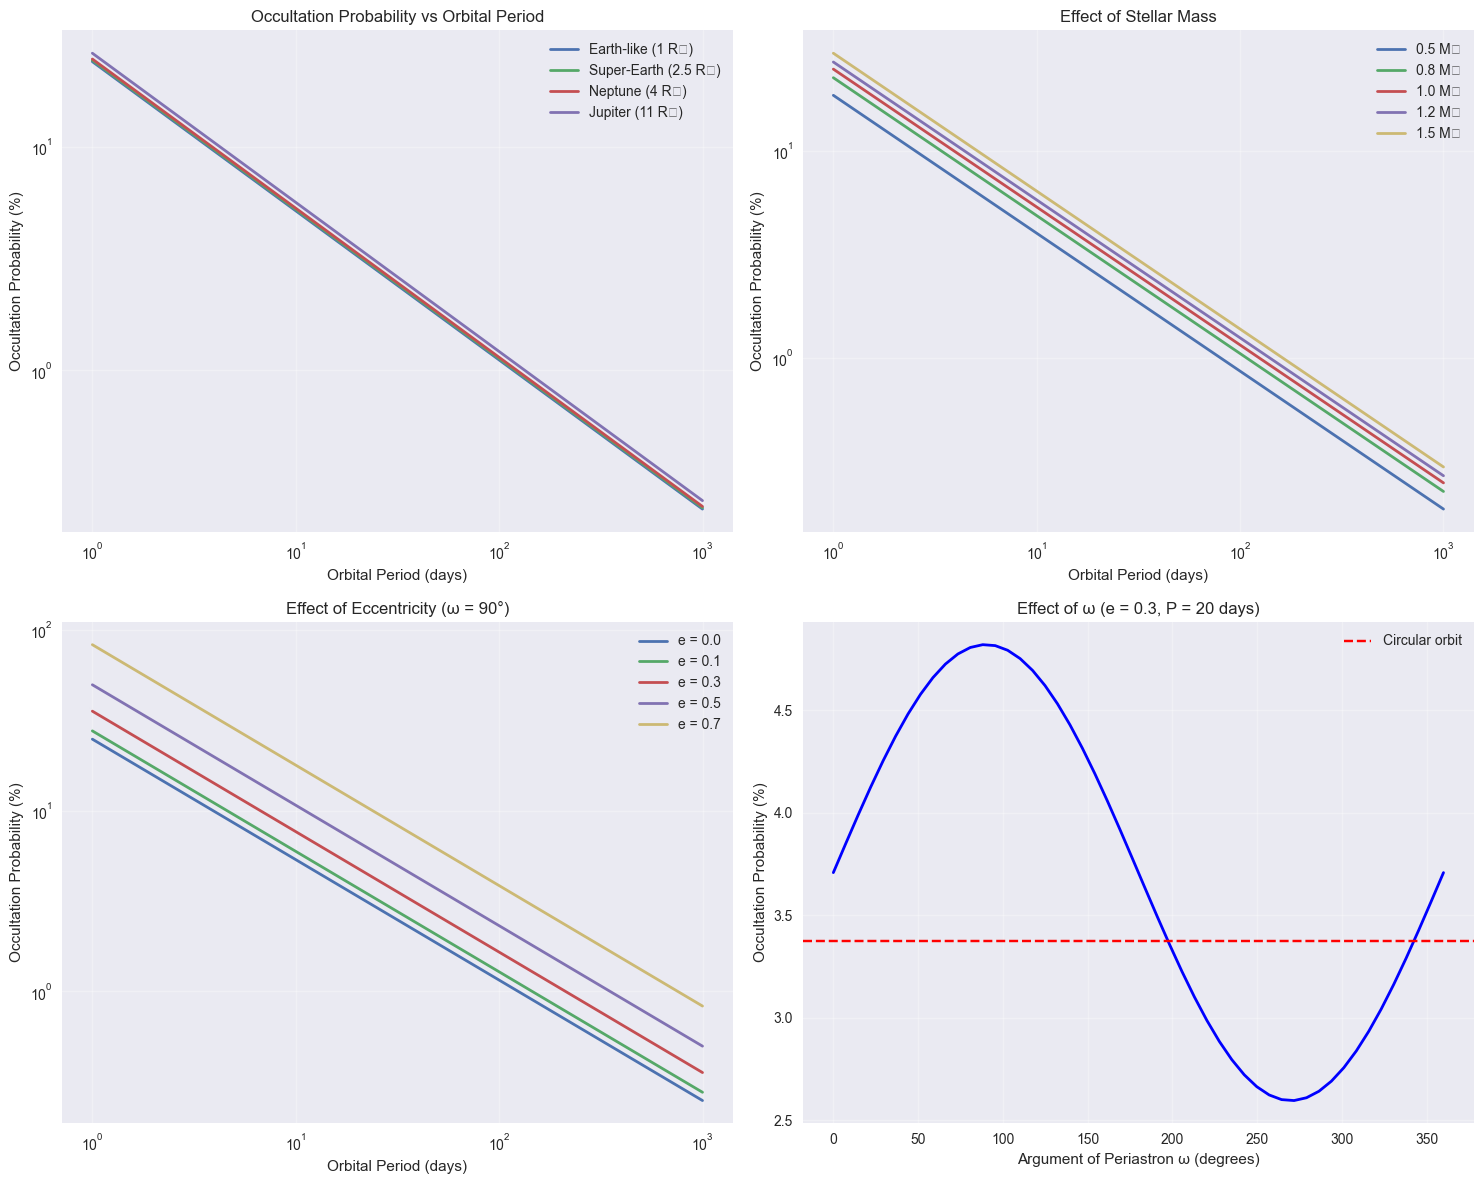

In [7]:
# Create comprehensive visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Probability vs Orbital Period for different planet types
periods = np.logspace(0, 3, 100)  # 1 to 1000 days
M_star = 1.0  # Solar mass

# Different planet types
planet_types = {
    'Earth-like (1 R⊕)': 1.0,
    'Super-Earth (2.5 R⊕)': 2.5, 
    'Neptune (4 R⊕)': 4.0,
    'Jupiter (11 R⊕)': 11.0
}

ax1 = axes[0, 0]
for name, radius in planet_types.items():
    probs = []
    for P in periods:
        result = calc.occultation_probability_from_params(P, M_star, radius)
        probs.append(result['probability_percent'])
    
    ax1.loglog(periods, probs, label=name, linewidth=2)

ax1.set_xlabel('Orbital Period (days)')
ax1.set_ylabel('Occultation Probability (%)')
ax1.set_title('Occultation Probability vs Orbital Period')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Effect of stellar mass
ax2 = axes[0, 1]
stellar_masses = [0.5, 0.8, 1.0, 1.2, 1.5]  # Solar masses
period_fixed = 10  # days
planet_radius = 5.0  # Earth radii

for M_s in stellar_masses:
    probs = []
    for P in periods:
        result = calc.occultation_probability_from_params(P, M_s, planet_radius)
        probs.append(result['probability_percent'])
    
    ax2.loglog(periods, probs, label=f'{M_s} M☉', linewidth=2)

ax2.set_xlabel('Orbital Period (days)')
ax2.set_ylabel('Occultation Probability (%)')
ax2.set_title('Effect of Stellar Mass')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Effect of eccentricity
ax3 = axes[1, 0]
eccentricities = [0.0, 0.1, 0.3, 0.5, 0.7]
omega = 90  # degrees (favorable for occultations)

for ecc in eccentricities:
    probs = []
    for P in periods:
        result = calc.occultation_probability_from_params(
            P, M_star, 5.0, eccentricity=ecc, omega_deg=omega)
        probs.append(result['probability_percent'])
    
    ax3.loglog(periods, probs, label=f'e = {ecc}', linewidth=2)

ax3.set_xlabel('Orbital Period (days)')
ax3.set_ylabel('Occultation Probability (%)')
ax3.set_title('Effect of Eccentricity (ω = 90°)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Effect of argument of periastron at fixed eccentricity
ax4 = axes[1, 1]
omegas = np.linspace(0, 360, 50)
ecc_fixed = 0.3
period_fixed = 20

probs_omega = []
for omega in omegas:
    result = calc.occultation_probability_from_params(
        period_fixed, M_star, 5.0, eccentricity=ecc_fixed, omega_deg=omega)
    probs_omega.append(result['probability_percent'])

ax4.plot(omegas, probs_omega, 'b-', linewidth=2)
ax4.axhline(y=calc.occultation_probability_from_params(period_fixed, M_star, 5.0)['probability_percent'], 
           color='r', linestyle='--', label='Circular orbit')
ax4.set_xlabel('Argument of Periastron ω (degrees)')
ax4.set_ylabel('Occultation Probability (%)')
ax4.set_title(f'Effect of ω (e = {ecc_fixed}, P = {period_fixed} days)')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Batch Processing: Analyze Multiple Systems

For analyzing multiple planetary systems at once:

In [8]:
def analyze_planet_list(planet_data):
    """
    Analyze multiple planets from a list of dictionaries.
    
    Parameters:
    -----------
    planet_data : list of dict
        Each dictionary should contain: name, period_days, M_star_solar, 
        R_planet_earth, and optionally eccentricity, omega_deg, R_star_solar
    
    Returns:
    --------
    pandas.DataFrame : Results for all planets
    """
    results = []
    
    for planet in planet_data:
        try:
            # Set defaults for optional parameters
            ecc = planet.get('eccentricity', 0.0)
            omega = planet.get('omega_deg', 90.0)
            R_star = planet.get('R_star_solar', None)
            
            result = calc.occultation_probability_from_params(
                period_days=planet['period_days'],
                M_star_solar=planet['M_star_solar'],
                R_planet_earth=planet['R_planet_earth'],
                eccentricity=ecc,
                omega_deg=omega,
                R_star_solar=R_star
            )
            
            # Add planet name and input parameters to result
            result['name'] = planet['name']
            result['input_period'] = planet['period_days']
            result['input_M_star'] = planet['M_star_solar']
            result['input_R_planet'] = planet['R_planet_earth']
            
            results.append(result)
            
        except Exception as e:
            print(f"Error processing {planet['name']}: {e}")
    
    # Create DataFrame and sort by probability
    df = pd.DataFrame(results)
    df = df.sort_values('probability_percent', ascending=False)
    
    return df

# Example: Analyze several known exoplanets
example_planets = [
    {
        'name': 'HD 209458 b',
        'period_days': 3.52,
        'M_star_solar': 1.12,
        'R_planet_earth': 13.4,
        'eccentricity': 0.0
    },
    {
        'name': 'WASP-12 b', 
        'period_days': 1.09,
        'M_star_solar': 1.35,
        'R_planet_earth': 18.9,
        'eccentricity': 0.05
    },
    {
        'name': 'Kepler-7 b',
        'period_days': 4.89,
        'M_star_solar': 1.35,
        'R_planet_earth': 15.6,
        'eccentricity': 0.0
    },
    {
        'name': 'GJ 436 b',
        'period_days': 2.64,
        'M_star_solar': 0.44,
        'R_planet_earth': 4.2,
        'eccentricity': 0.16,
        'omega_deg': 351
    },
    {
        'name': 'Proxima Cen b',
        'period_days': 11.19,
        'M_star_solar': 0.12,
        'R_planet_earth': 1.1,
        'eccentricity': 0.1
    }
]

# Analyze the example planets
print("Analyzing Example Exoplanets")
print("=" * 50)
results_df = analyze_planet_list(example_planets)

# Display results
display_cols = ['name', 'probability_percent', 'semi_major_axis_AU', 
                'input_period', 'input_M_star', 'input_R_planet']
print(results_df[display_cols].round(4))

Analyzing Example Exoplanets
            name  probability_percent  semi_major_axis_AU  input_period  \
1      WASP-12 b              30.8737              0.0229          1.09   
0    HD 209458 b              12.0436              0.0470          3.52   
2     Kepler-7 b              10.5571              0.0623          4.89   
3       GJ 436 b               9.1179              0.0284          2.64   
4  Proxima Cen b               2.0705              0.0483         11.19   

   input_M_star  input_R_planet  
1          1.35            18.9  
0          1.12            13.4  
2          1.35            15.6  
3          0.44             4.2  
4          0.12             1.1  


## Summary and Key Insights

### Key Takeaways:

1. **Geometric Nature**: Occultation probability is fundamentally geometric, depending on the chance that Earth lies within the planet's shadow cone.

2. **Period Dependence**: Probability scales roughly as P^(-2/3) due to Kepler's third law - closer planets have higher probabilities.

3. **Size Matters**: Both stellar and planetary radii contribute positively to probability.

4. **Eccentricity Effects**: 
   - For eccentric orbits, probability depends on argument of periastron (ω)
   - ω ≈ 90° maximizes occultation probability
   - ω ≈ 270° minimizes it

5. **Practical Ranges**:
   - Hot Jupiters: ~1-30% probability
   - Warm planets: ~0.1-5% probability  
   - Habitable zone planets: ~0.001-0.1% probability

### Usage Notes:

- This calculator assumes the planet and star can be treated as point/spherical objects
- It neglects atmospheric effects and limb darkening
- For highly eccentric orbits (e > 0.8), more sophisticated analysis may be needed
- The stellar radius estimation is approximate - use measured values when available

### References:

- Winn, J. N. (2014). "Transits and Occultations." arXiv:1001.2010
- Seager, S. & Mallén-Ornelas, G. (2003). "A Unique Solution of Planet and Star Parameters from an Extrasolar Planet Transit Light Curve." ApJ 585, 1038
- Kane, S. R. & von Braun, K. (2008). "Constraining the False Positive Rate for Kepler Planet Candidates with Multicolour Photometry from the GTC." ApJ 689, 492

## Quick Usage Guide

### For a Single Planet:

```python
# Simple case - just provide basic parameters
result = calc.occultation_probability_from_params(
    period_days=10.0,      # Orbital period
    M_star_solar=1.0,      # Stellar mass in solar masses
    R_planet_earth=5.0     # Planet radius in Earth radii
)
print(f"Occultation probability: {result['probability_percent']:.3f}%")
```

### For Multiple Planets:

```python
# Create list of planet dictionaries
my_planets = [
    {'name': 'Planet A', 'period_days': 5.0, 'M_star_solar': 1.2, 'R_planet_earth': 3.0},
    {'name': 'Planet B', 'period_days': 15.0, 'M_star_solar': 0.8, 'R_planet_earth': 7.0}
]

# Analyze all planets
results = analyze_planet_list(my_planets)
print(results[['name', 'probability_percent']])
```

### To Modify the Interactive Calculator:

Simply edit the parameters in the `calculate_custom_system()` function above and re-run the cell!

**This notebook is now ready for your occultation probability calculations! 🌟**